# Raport nr 1, Symulacje komputerowe

###  Emil Olszewski, Artur Sadurski  
---  

In [1]:
using Plots
using Distributions
using HypothesisTests
using BenchmarkTools
using BenchmarkPlots
using Statistics
using StatsPlots
using KernelDensity
using SpecialFunctions
using LinearAlgebra

**Zadanie 1**  
Generator liczb pseudolosowych

Poniżej znajduje się implementacja generatora MRG32k3a liczb pseudolosowych z rozkładu jednostajnego na odcinku [0, 1]

In [2]:
function MRG32k3a(
    size, 
    seedx = [1822406609, 1153072917, 1254937013], 
    seedy = [2311980605, 7239483046, 2394024690]
    )

    result = Vector{Float64}(undef, size)

    m1 = 2^32 - 209
    m2 = 2^32 - 22853

    for i in 1:size

        x = mod((1403580seedx[2] - 810728seedx[3]), m1)
        y = mod((527612seedy[1] - 1370589seedy[3]), m2)

        result[i] = ifelse(x > y, (x - y) / (m1 + 1), (x - y + m1) / (m1 + 1))

        # Do generowania realizacji zmiennej losowej potrzebujemy tylko 3 ostatnich 
        # wartości x i y. Tym samym seedx i seedy możemy traktować jako kolejkę, w
        # każdej iteracji odrzucając wartości z końca i dodanjąc nowo obliczone 
        # wartości do początku. 
        
        pop!(seedx); pop!(seedy)
        pushfirst!(seedx, x); pushfirst!(seedy, y)

    end

    return result

end

MRG32k3a (generic function with 3 methods)

In [ ]:
UNIFORM_SAMPLE_SIZE = 10_000
mrg_samples = MRG32k3a(UNIFORM_SAMPLE_SIZE)
scatter(mrg_samples, markersize=1, color=:dodgerblue1, legend=nothing, title="Realizacje algorytmu MRG32k3a")

Jak widać liczby generowane przez *MRG32k3a* rozkładają się w miarę równomiernie na odcinku [0, 1]. Skłania nas to do stwierdzenia, że pochodzą one z rozkładu U(0, 1). Aby potwierdzić tą hipotezę, wykonamy histogram generowanych wartości i przeprowadzimy test Kołmogorowa-Smirnoffa.

In [ ]:
histogram(mrg_samples, color=:dodgerblue1, label="Rozkład otrzymanych wartości", normalize=:pdf, legend=:outerbottom)
plot!(x -> (0 < x < 1), lw=5, color=:orange, label="Gęstość rozkładu U(0, 1)")

In [ ]:
ExactOneSampleKSTest(mrg_samples, Uniform(0, 1))

Powyższy histogram dobrze obrazuje jednostajność generowanych wartości. Jednakże nie mówi nic o niezależności. Sprawdzimy teraz kilka cech, które powinny charakteryzować ciąg niezależnych zmiennych losowych. 

* $Cov(X,Y) = 0$  
   
Jeśli dwie zmienne losowe są niezależne, to $$Cov(X, Y) = E(XY) - E(X)E(Y) = 0$$  
Zauważmy, że implikacja w drugą stronę nie zachodzi, jednakże brak powyższej równości, wyklucza niezależność zmiennych.

In [ ]:
covariances = zeros(100)

for i in 1:100
    seedx1 = rand(Int, 3)
    seedy1 = rand(Int, 3)
    X = MRG32k3a(100_000, rand(Int, 3), rand(Int, 3))
    Y = MRG32k3a(100_000, rand(Int, 3), rand(Int, 3))
    covariances[i] = mean(X .* Y) - mean(X) * mean(Y)
end

print("Średnia wartość |Cov(X,Y)|: ", mean(abs.(covariances)))

Jak widać, średnia wartość modułu kowariancjii jest bardzo mała, co świadczy o nieskorelowaniu ciągów generowanych przez algorytm *MRG32k3a* z losowym ziarnem.

* Rozkład zmiennej $|X - Y|$
  
Sprawdzimy teraz czy kolejne wartości ciągu generowanego przez algorytm są niezależne względem siebie. Jeśli następujące po sobie wartości są *iid* (independent, identically distrubuted), to rozkład $|x[i + 1] - x[i]|$ zadany jest wzorem 

$$ f(x) = 2\,\int_0^\infty g(x + y)g(y)\,dy = 2(1 - x) \quad dla \; x \in [0,1]$$  

gdzie $g(x)$ jest gęstością rozkładu jednostajnego na odcinku [0, 1].  
Powyższe równanie wynika ze wzoru na gęstość różnicy niezależnych zmiennych losowych i gęstość odwzorowania zmiennej losowej przez funkcję mierzalną. 

In [ ]:
distances = [abs(mrg_samples[i + 1] - mrg_samples[i]) for i in 1:UNIFORM_SAMPLE_SIZE - 1]
histogram(distances, color=:dodgerblue1, label="Odległości pomiędzy kolejnymi wartościami", normalize=:pdf, legend=:outerbottom)
plot!(x -> 2 * (1 - x) * (0 < x < 1), lw = 5, color=:orange, label="Gęstość oczekiwanego rozkładu")

In [ ]:
ExactOneSampleKSTest(distances, TriangularDist(0, 1, 0))

Powyższy test oraz histogram wskazują na to, że odległości pomiędzy wygenerowanymi liczbami są z rozkładu trójkątnego o parmatrach $(0, 1, 0)$. Jest to kolejna przesłanka za tym, że algorytm generuje wartości *iid*. 

Na sam koniec porównamy wydajność naszego algorytmu do wbudowanej funkcji `rand`.

In [ ]:
@benchmark MRG32k3a(UNIFORM_SAMPLE_SIZE)

In [ ]:
@benchmark rand(UNIFORM_SAMPLE_SIZE)

Nasza implementacja generatora liczb pseudolosowych jest znacznie wolniejsza od wbudowanej metody (735 mikrosekund vs. 86 mikrosekund dla próbki o długości 10 000), jednakże zużywa porównywalne zasoby pamięci.

---

**Zadanie 2**

Generowanie rozkładu Poissona z rozkładu geometrycznego metodą akceptacji odrzucenia. 

In [ ]:
poisson_param = 2
geometric_param = 1/4

In [ ]:
poisson(n, λ) = exp(-λ) * λ^n / factorial(big(n))
geometric(n, p) = (1 - p)^n * p

In [ ]:
c = maximum(poisson(n) / geometric(n) for n in 1:10)

In [ ]:
function accept_reject(c_param, g_param, p_param)

    dist = Geometric(g_param)
    x = rand(dist)

    while c_param * rand() * geometric(x, g_param) > poisson(x, p_param)
        x = rand(dist)
    end

    return x

end



In [ ]:
function accept_reject_vectorized(size, c_param, g_param, p_param)

    result = Vector{Int}(undef, size)
    dist = Geometric(g_param)

    for i in 1:size

        x = rand(dist)
        
        while c * rand() * geometric(x, g_param) > poisson(x, p_param)
            x = rand(dist)
        end

        result[i] = x

    end

    return result

end

In [ ]:
@benchmark [accept_reject(c, geometric_param, poisson_param) for _ in 1:10_000]

In [ ]:
@benchmark accept_reject_vectorized(10_000, c, geometric_param, poisson_param)

In [ ]:
poisson_samples =  accept_reject_vectorized(100_000)

In [ ]:
histogram(poisson_samples, normalize=:probability, color=:dodgerblue1, label="Rozkład wygenerowanych wartości", legend=:outerbottom)
scatter!(0:10, pdf.(Poisson(poisson_param), 0:10), color=:orange, label="Rozkład Poissona z parametrem: $(poisson_param)")

Przy przeprowadzeniu testu Kołmogorowa-Smirnova trzeba mieć na uwadze, że zakłada on brak powtarzających się wartości w analizowanej próbie. Jest to duży problem w przypadku rozkładów dyskretnych, gdzie te wartości naturalnie będą się powtarzać. W związku z tym wprowadzimy nieznaczny szum, który sprawi, że wartości nie będą się powtarzać, a zarazem nie zmieni charakteru rozkładu. Jest to rozwiązanie podane w poście znajdującym się pod linkiem: https://discourse.julialang.org/t/kolmogorov-smirnov-test/89990/9 

In [ ]:
ApproximateTwoSampleKSTest(
    poisson_samples .+ rand(100_000) / 100,
    rand(Poisson(poisson_param), 100_000) .+ rand(100_000) / 100
)

Jak widać prawdopodobieństwo tego, że `poisson_samples` pochodzi z rozkładu Poissona potwierdza nam poprawność działania metody `accept_reject`.

---  

**Zadanie 3**  

Generowanie rozkładu normalnego z rozkładu wykładniczego metodą zigguratu.

In [ ]:
# Znajdź indeks i taki, że xᵢ < x <= xᵢ₊₁
function findindex(x, interval)
    i = 1
    while x > interval[i] && i < length(interval)
        i += 1
    end
    i - 1
end

In [ ]:
# Wygeneruj listę przedziałów [xᵢ, xᵢ₊₁] oraz listę ekstremów na tych przedziałach 
function steps(resolution :: Int)

    # Ze względu na to, że gęstość |N(0, 1)| jest ściśle malejąca na swojej dziedzinie, to maksimum będzie się znajdować 
    # na początku przedziału a minimum na końcu przedziału 

    # Minimum z przedziału [xᵢ, xᵢ₊₁] jest maksimum z przedziału [xᵢ₊₁, xᵢ₊₂]

    xs = LinRange(0, 5, resolution)

    ys = 2 .* pdf.(Normal(0, 1), xs)
    push!(ys, 0)

    return (xs, ys)

end

In [ ]:
function ziggurat(N, intervals, extr)

    samples = Vector{Float64}(undef, N)
    counts = 0

    for i = 1:N
        
        x = 0.
        # Zmienne do zliczania częstości wywołań gęstości rozkładu normalnego 
        counter = 0      
        num_of_runs = 0
        
        while true 
         
            x = rand(Exponential(1))
            y = sqrt(2ℯ/π) * rand() * pdf(Exponential(1), x)
            
            idx = findindex(x, intervals)
            num_of_runs += 1
            
            # Jeśli y jest większy niż maksimum na danym przedziale, to odrzucamy wylosowaną wartość.
            if y > extr[idx] 
                continue
            end

            # Jeśli mniejszy niż minimum to akceptujemy.
            if y < extr[idx + 1]
                break
            end

            # Tylko gdy oba powyższe warunki nie są spełnione to obliczamy gęstość rozkładu normalnego.
            if y <= 2 * pdf(Normal(0, 1), x)
                counter += 1
                break
            end

        end

        samples[i] = x
        
        # Częstość wywoływania gęstości rozkładu normalnego.
        counts += counter / num_of_runs
    end

    return (samples, counts/N)

end

In [ ]:
# Tradycyjna metoda akceptacji-odrzucenia
function basic_accept_reject(N)
    
    result = Vector{Float64}(undef, N)

    for i in 1:N
        x = rand(Exponential(1))
        y = sqrt(2ℯ/π) * rand() * pdf(Exponential(1), x)
        while y > 2 * pdf(Normal(0, 1), x)
            x = rand(Exponential(1))
            y = sqrt(2ℯ/π) * rand() * pdf(Exponential(1), x)
        end
        result[i] = x
    end

    return result
end

Sprawdzimy teraz dla jakiej ilości przedziałów metoda zigguratu działa najwydajniej czasowo.

In [ ]:
times = Vector{Float64}(undef, 50)
number_of_runs = 5

for num_of_steps in 2:51
    
    total_time = 0
    intervals, extr = steps(num_of_steps)

    for run in 1:number_of_runs
        
        time = time_ns()
        ziggurat(10_000, intervals, extr)
        time = time_ns() - time 
        total_time += time

    end

    # Średni czas obliczenia funkcji ziggurat
    times[num_of_steps - 1] = total_time/number_of_runs

end

In [ ]:
scatter(times[2:end])

In [ ]:
intervals, extr = steps(30)

In [ ]:
@benchmark ziggurat(1_000_000, intervals, extr)

In [ ]:
@benchmark basic_accept_reject(1_000_000)

Zwróćmy teraz uwagę na fakt, że funkcja `ziggurat` generuje wartości z rozkładu $|N(0, 1)|$. Rozkład $ N(0, 1)$ uzyskamy łącząc uzyskany wektor z wektorem do niego przeciwnym. Tym samym w celu uzyskania próby o długości $ n$ wystarczy wysymulować tylko próbę o długości $\frac{n}{2}$.  

In [ ]:
@benchmark ziggurat(500_000, intervals, extr)

In [ ]:
abs_norm_samples, mean_pdf_calls_rate = ziggurat(50_000, intervals, extr)
print("Średnia częstość wywołań gęstości rozkładu normalnego: $(mean_pdf_calls_rate)")

In [ ]:
norm_samples = vcat(abs_norm_samples, -abs_norm_samples)
xs = LinRange(-3, 3, 60)

histogram(norm_samples, normalize=:pdf, label="Rozkład wartości wygenerowanych metodą zigguratu", color=:dodgerblue1, legend=:outerbottom)
plot!(xs, pdf.(Normal(0, 1), xs), label="Gęstość standardowego rozkładu normalnego", lw=4, color=:orange)

In [ ]:
ExactOneSampleKSTest(norm_samples, Normal(0, 1))

In [ ]:
kern = kde(norm_samples)
plot(xs, pdf.(Normal(0, 1), xs), label="Gęstość standardowego rozkładu normalnego", color=:orange, legend=:outerbottom)
plot!(xs, pdf(kern, xs), label="Jądrowy estymator gęstości", color=:green3)

---

**Zadanie 4**   

Porównanie różnych metod generowania rozkładu normalnego

In [ ]:
SAMPLESIZE = 100_000

* Metoda wbudowana `randn`

In [ ]:
@benchmark randn(SAMPLESIZE)

In [ ]:
builtin_sample = randn(SAMPLESIZE)
ExactOneSampleKSTest(builtin_sample, Normal(0, 1))

* Metoda odwrotnej dystrybuanty 

Dystrybuanta standardowego rozkładu normalnego $\Phi$ zadana jest wzorem

$$\Phi(x) = \frac{1}{2}\,\mathit{erfc}(-\frac{x}{\sqrt{2}})$$ 

gdzie $\mathit{erfc}(x) = \frac{2}{\sqrt{\pi}}\,\int_x^\infty e^{-t^2}\,dt$.  
W związku z tym 

$$\Phi^{-1}(x) = -\sqrt{2}\,\mathit{erfc}^{-1}(2x)$$

Do obliczenia odwrotnej dystrybuanty standardowego rozkładu normalnego skorzystamy z funkcji `erfcinv` z pakietu `SpecialFunctions`.

In [ ]:
inversecdf(x) = -sqrt(2) * erfcinv(2x)

In [ ]:
function inv(size)
    return inversecdf.(rand(size))
end

In [ ]:
@benchmark inv(SAMPLESIZE)

In [ ]:
inversecdf_samples = inv(SAMPLESIZE)
ExactOneSampleKSTest(inversecdf_samples, Normal(0, 1))

* Metoda Boxa - Mullera 

W tej metodzie skorzystamy z następującego faktu.  
$$\frac{1}{2}R^2 \sim \mathit{Exp}(1) \wedge \Theta \sim U(0, 2\pi) \implies R\sin(\Theta) \sim N(0, 1)$$

In [ ]:
function boxmuller(size)

    θ = 2π .* rand(size)
    R = sqrt.(2 .* rand(Exponential(1), size))

    return R .* sin.(θ)
end

In [ ]:
@benchmark boxmuller(SAMPLESIZE)

In [ ]:
boxmuller_samples = boxmuller(SAMPLESIZE)
ExactOneSampleKSTest(boxmuller_samples, Normal(0, 1))

* Metoda Marsaglii

Metoda Marsaglii jest modyfikacją algorytmu Boxa-Mullera, w której zamiast obliczać wartość sinusa wbudowaną funkcją `sin`, generujemy punkt z koła jednostkowego i używamy jego współrzędnych.  

In [ ]:

function marsaglia(size)

    result = Vector{Float64}(undef, size)

    for i in 1:size
        
        # Punkt z rozkładu jednostajnego na kwadracie [-1, 1]²
        x = 2 * rand() - 1
        y = 2 * rand() - 1

        # Powtarzaj dopóki wylosowany punkt nie znajduje się wewnątrz koła.
        while x^2 + y^2 > 1
            x = 2 * rand() - 1
            y = 2 * rand() - 1
        end

        s = x^2 + y^2

        result[i] = x * sqrt(-2log(s) / s)
    end

    return result
end

In [ ]:
@benchmark marsaglia(SAMPLESIZE)

Porównamy teraz wydajność czterech przedstawionych wyżej metod

In [ ]:
function compare_eff(size)
    
    suite = BenchmarkGroup()
    for f in (boxmuller, marsaglia, randn, inv)
        suite[string(f)] = @benchmarkable $(f)($size)
    end
    tune!(suite)
    run(suite, samples=50)

end

In [ ]:
bench_results = compare_eff(SAMPLESIZE)

In [ ]:
plot(bench_results)

---

**Zadanie 5** 

Zależność zmiennych losowych. 



Aby wygenerować dwie zależne zmienne losowe skorzystamy z dwywymiarowego rozkładu normalnego o danej macierzy kowariancji. 

Niech $\Sigma$ będzie symetryczną macierzą 2x2, a $X$ i $Y$ niezależnymi zmiennymi losowymi ze standardowego rozkładu normalnego. $\Sigma$ da się rozpisać jako iloczyn macierzy górno i dolno-trójkątnych $\Sigma = A\,A^T$. Wtedy $(A\,X,\; A\,Y)$ pochodzi z dwuwymiarowego rozkładu normalnego o macierzy kowariancji $\Sigma$.

In [3]:
function multivariate_normal(size :: Int, dim :: Int, covariance_matrix :: Matrix = [1 0; 0 1], means_vector :: Vector = [0, 0])

    result = Matrix{Float64}(undef, size, dim)

    # Rozkład macierzy kowariancji 
    A = cholesky(covariance_matrix).L
    
    for i = 1:size
        result[i, :] = A * randn(dim) + means_vector
    end

    return result

end

multivariate_normal (generic function with 3 methods)

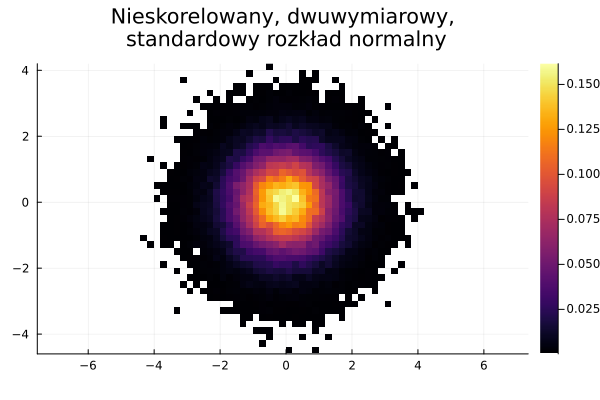

In [4]:
not_cor_sample = multivariate_normal(100_000, 2)
histogram2d(not_cor_sample[:, 1], not_cor_sample[:, 2], normalize=:pdf, aspect_ratio=1, title="Nieskorelowany, dwuwymiarowy,\n standardowy rozkład normalny")

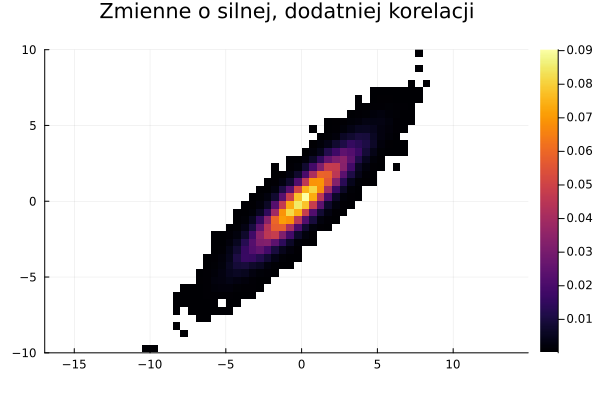

In [6]:
high_pos_cor = [4 3.6; 3.6 4]
high_pos_sample = multivariate_normal(100_000, 2, high_pos_cor)
histogram2d(high_pos_sample[:, 1], high_pos_sample[:, 2], normalize=:pdf, aspect_ratio=1, title="Zmienne o silnej, dodatniej korelacji")

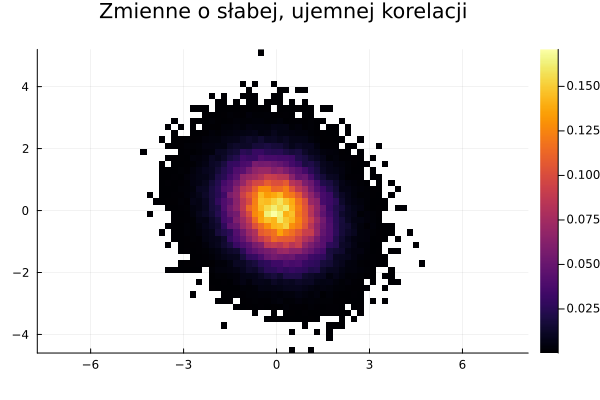

In [7]:
low_neg_cor = [1 -0.2; -0.2 1]
low_neg_sample = multivariate_normal(100_000, 2, low_neg_cor)
histogram2d(low_neg_sample[:, 1], low_neg_sample[:, 2], normalize=:pdf, aspect_ratio=1, title="Zmienne o słabej, ujemnej korelacji")

* Zmienne nieskorelowane $\rho_{XY} = 0$

In [8]:
not_cor_test_sample = multivariate_normal(100_000, 2, [4 0; 0 9], [-2, 3])
X1 = not_cor_test_sample[:, 1]  # X z rozkładu N(-2, 2)
Y1 = not_cor_test_sample[:, 2]  # Y z rozkładu N(3, 3)

100000-element Vector{Float64}:
  0.9027098451188533
  1.0954354565709576
  5.4196924274473535
  7.40574555527286
  1.3352443472135613
 -2.1147268830139687
  9.025911186104862
  6.116454129523735
  4.471652595132427
 -0.5741814094914575
  ⋮
  1.7548289098791743
 -1.6682750812123066
  1.1235288466146662
  3.3578648764426955
  8.605085929089539
  6.606973466311373
  4.347993127855285
  6.95488919707327
 -0.028168534764775544

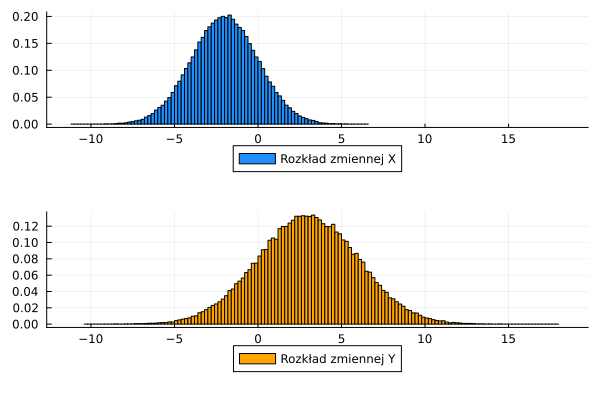

In [9]:
h1 = histogram(X1, normalize=:pdf, color=:dodgerblue1, label="Rozkład zmiennej X", legend=:outerbottom)
h2 = histogram(Y1, normalize=:pdf, color=:orange, label="Rozkład zmiennej Y", legend=:outerbottom)
plot(h1, h2, link=:x, layout=@layout grid(2, 1))


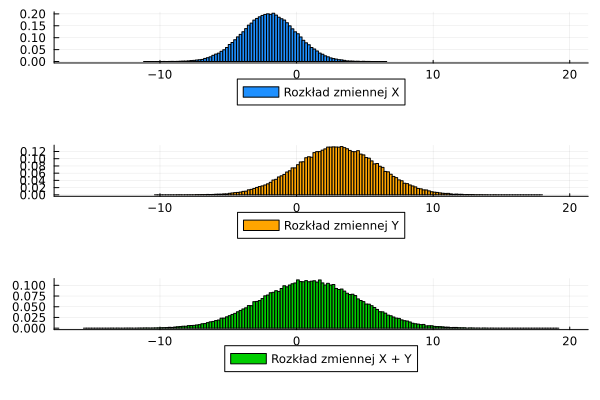

In [10]:
Z1 = X1 .+ Y1
h3 = histogram(X1 .+ Y1, normalize=:pdf, color=:green3, label="Rozkład zmiennej X + Y", legend=:outerbottom)
plot(h1, h2, h3, layout=(@layout grid(3, 1)), link=:x)

Jak widzimy $X + Y$ też wydaje się mieć rozkład normalny. Jesteśmy w stanie wyliczyć wartość oczekiwaną ze wzoru 

$$E(X \pm Y) = E(X) \pm E(Y)$$
dla dowolnych zmiennych losowych $X$ i $Y$.

Odchylenie standardowe obliczymy zaś ze wzoru 

$$D^2(X \pm Y) = D^2(X) + D^2(Y)$$ 
dla nieskorelowanych zmiennych losowych.

Z tego wynika, że 

$$D(X \pm Y) = \sqrt{D^2(X) + D^2(Y)}$$

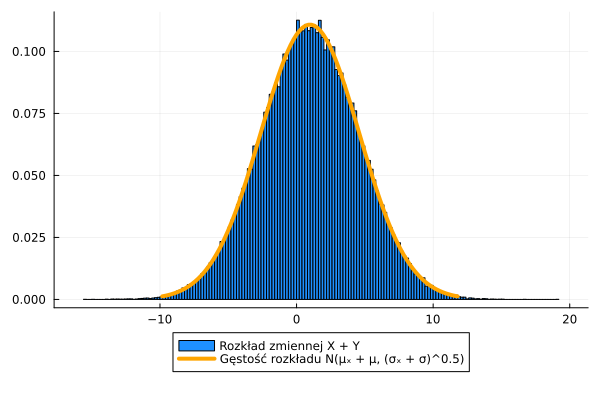

In [11]:
histogram(Z1, normalize=:pdf, color=:dodgerblue1, label="Rozkład zmiennej X + Y", legend=:outerbottom)
plot!(
    LinRange(mean(Z1) - 3std(Z1), mean(Z1) + 3std(Z1), 100),
    pdf.(Normal(mean(X1) + mean(Y1), sqrt(var(X1) + var(Y1))), LinRange(mean(Z1) - 3std(Z1), mean(Z1) + 3std(Z1), 100)),
    color=:orange,
    lw=4,
    label="Gęstość rozkładu N(μₓ + μ, (σₓ + σ)^0.5)"
)

Testem Kołmogorowa-Smirnova sprawdzimy, czy rzeczywiście 

$$X + Y \sim N\left(\mu_X + \mu_Y, \sqrt{\sigma_X^2 + \sigma_Y^2}\right)

In [12]:
ExactOneSampleKSTest(Z1, Normal(mean(X1) + mean(Y1), sqrt(var(X1) + var(Y1))))

Exact one sample Kolmogorov-Smirnov test
----------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.00246218

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.5793

Details:
    number of observations:   100000


Test potwierdza nasze przypuszczenia. 

Analogiczne rozumowanie stosujemy do różnicy $X - Y$.

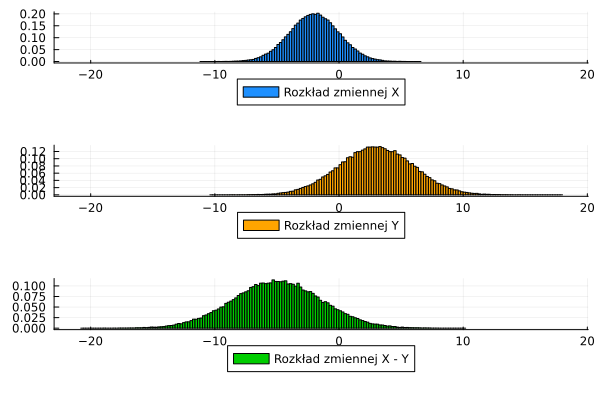

In [13]:
W1 = X1 .- Y1
h4 = histogram(W1, normalize=:pdf, color=:green3, label="Rozkład zmiennej X - Y", legend=:outerbottom)
plot(h1, h2, h4, link=:x, layout=@layout grid(3, 1))

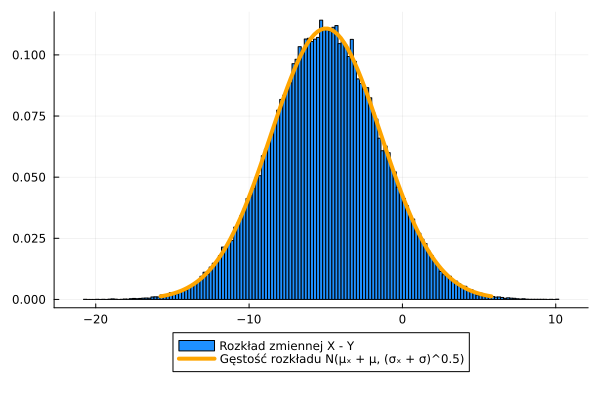

In [14]:
histogram(W1, normalize=:pdf, color=:dodgerblue1, label="Rozkład zmiennej X - Y", legend=:outerbottom)
plot!(
    LinRange(mean(W1) - 3std(W1), mean(W1) + 3std(W1), 100),
    pdf.(Normal(mean(X1) - mean(Y1), sqrt(var(X1) + var(Y1))),
    LinRange(mean(W1) - 3std(W1), mean(W1) + 3std(W1), 100)),
    color=:orange,
    lw=4,
    label="Gęstość rozkładu N(μₓ + μ, (σₓ + σ)^0.5)"
)


In [15]:
ExactOneSampleKSTest(W1, Normal(mean(X1) - mean(Y1), sqrt(var(X1) + var(Y1))))

Exact one sample Kolmogorov-Smirnov test
----------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.00195537

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.8391

Details:
    number of observations:   100000


W przypadku nieskorelowanych zmiennych ze standardowego rozkładu normalnego, suma $X + Y$ ma rozkład $\Chi^2(2)$. 

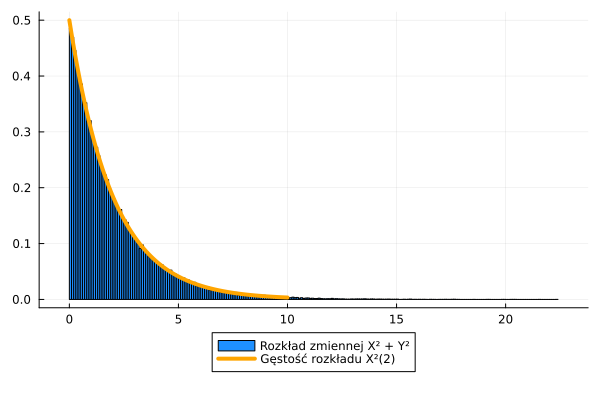

In [16]:
R1 = randn(100_000).^2 + randn(100_000).^2 
histogram(R1, normalize=:pdf, color=:dodgerblue1, label="Rozkład zmiennej X² + Y²", legend=:outerbottom)
plot!(
    LinRange(0, 10, 100),
    pdf.(Chisq(2), LinRange(0, 10, 100)),
    label="Gęstość rozkładu Χ²(2)",
    lw = 4,
    color=:orange
)

* Zmienne o niezerowej korelacji

Wygenerujemy teraz silnie, dodatnio skorelowane zmienne: 
$$X \sim N(3, 2)$$
$$Y \sim N(-2, 4)$$
$$\rho_{XY} = 0.9$$

In [17]:
strong_pos_sample = multivariate_normal(100_000, 2, [4 7.2; 7.2 16], [3, -2])
X2 = strong_pos_sample[:, 1]
Y2 = strong_pos_sample[:, 2]

100000-element Vector{Float64}:
  -8.56220419463732
  -6.229092094048358
 -12.197763339767487
  -2.589146995881478
  -0.8724307415160171
  -2.4906533149839305
  -1.6385852395549725
  -3.5805085212979604
   5.356535294874165
  -7.961593252002636
   ⋮
  -1.9047349792925632
  -3.4243251507736443
  -4.528837369190985
   0.405181942802626
   0.8942724695783344
   2.441072022915809
   6.781082473411399
  -5.57004830563824
  -5.283878338748507

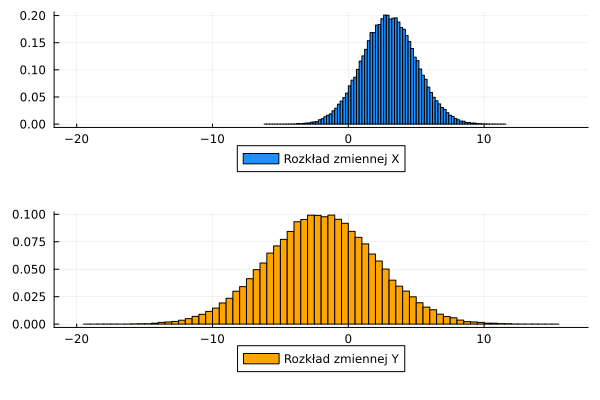

In [18]:
h5 = histogram(X2, normalize=:pdf, color=:dodgerblue1, label="Rozkład zmiennej X", legend=:outerbottom)
h6 = histogram(Y2, normalize=:pdf, color=:orange, label="Rozkład zmiennej Y", legend=:outerbottom)

plot(h5, h6, link=:x, layout=@layout grid(2, 1))

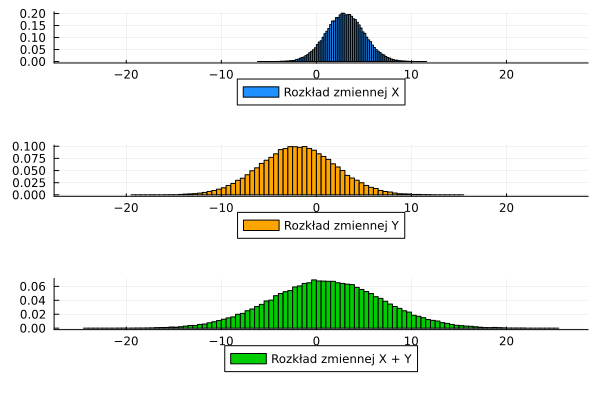

In [19]:
Z2 = X2 .+ Y2 
h7 = histogram(X2 .+ Y2, normalize=:pdf, color=:green3, label="Rozkład zmiennej X + Y", legend=:outerbottom)
plot(h5, h6, h7, layout=(@layout grid(3, 1)), link=:x)

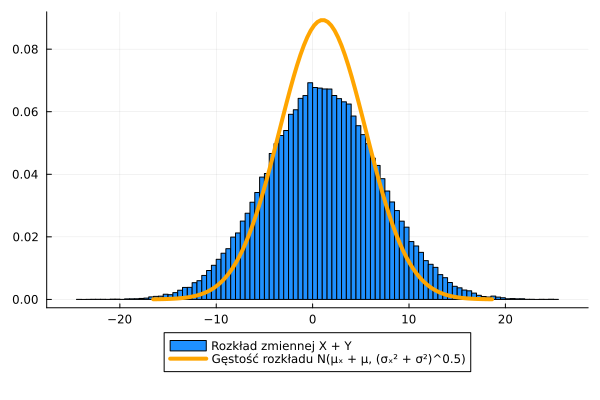

In [20]:
histogram(Z2, normalize=:pdf, color=:dodgerblue1, label="Rozkład zmiennej X + Y", legend=:outerbottom)
plot!(
    LinRange(mean(Z2) - 3std(Z2), mean(Z2) + 3std(Z2), 100),
    pdf.(Normal(mean(X2) + mean(Y2), sqrt(var(X2) + var(Y2))), LinRange(mean(Z2) - 3std(Z2), mean(Z2) + 3std(Z2), 100)),
    color=:orange,
    lw=4,
    label="Gęstość rozkładu N(μₓ + μ, (σₓ² + σ²)^0.5)"
)

Patrząc na histogram można przypuszczać, że suma X + Y nadal pochodzi z rozkładu normalnego, ale źle dobrane jest odchylenie standardowe. Przeporwadzimy test Jarque-Bera, żeby sprawdzić, czy X + Y nadal ma rozkład normalny.

In [21]:
JarqueBeraTest(Z2)

Jarque-Bera normality test
--------------------------
Population details:
    parameter of interest:   skewness and kurtosis
    value under h_0:         "0 and 3"
    point estimate:          "0.012293538343385844 and 2.999742953964069"

Test summary:
    outcome with 95% confidence: fail to reject h_0
    one-sided p-value:           0.2838

Details:
    number of observations:         100000
    JB statistic:                   2.51913


Jak widać z powyższego testu suma skorelowanych zmiennych losowych z rozkładu normalnego też pochodzi z rozkładu normalnego, ale nie zachodzą już wzory na sumowanie się wariancji. 

Możemy skorzystać z bardziej ogólnego wzoru, który nie zakłada nieskorelowania.

$$D^2(X \pm Y) = D^2X + D^2Y \pm 2\mathit{Cov}(X, Y)$$

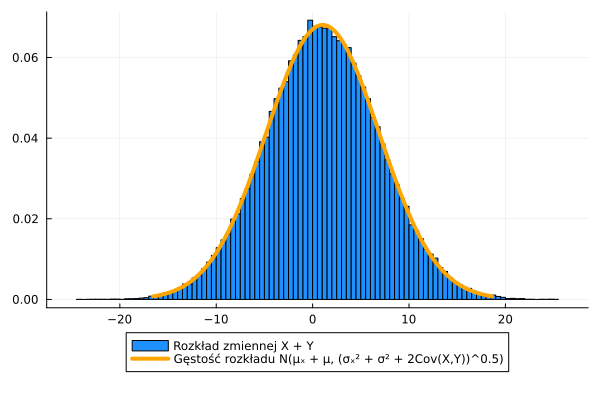

In [22]:
histogram(Z2, normalize=:pdf, color=:dodgerblue1, label="Rozkład zmiennej X + Y", legend=:outerbottom)
plot!(
    LinRange(mean(Z2) - 3std(Z2), mean(Z2) + 3std(Z2), 100),
    pdf.(Normal(mean(X2) + mean(Y2), sqrt(var(X2) + var(Y2) + 2cov(X2, Y2))), LinRange(mean(Z2) - 3std(Z2), mean(Z2) + 3std(Z2), 100)),
    color=:orange,
    lw=4,
    label="Gęstość rozkładu N(μₓ + μ, (σₓ² + σ² + 2Cov(X,Y))^0.5)"
)

Z powyższego wzoru widać, że dla dodatnio skorelowanych zmiennych $X$ i $Y$ czym większa ich kowariancja, tym większe będzie odchylenie standardowe ich sumy. Odwrotnie się dzieje dla różnicy $X - Y$.   
Gdy $X$ i $Y$ są ujemnie skorelowane ($\mathit{Cov}(X,Y) < 0$), większa (co do modułu) kowariancja zmniejsza odchylenie standardowe sumy, zaś zwiększa różnicy.

Teraz sprawdzimy jak skorelowanie wpływa na rozkład $X^2 + Y^2$, gdzie $X,Y \sim N(0, 1)$.

Plots.AnimatedGif("C:\\Users\\eemil\\AppData\\Local\\Temp\\jl_RSpqlGZcLs.gif")
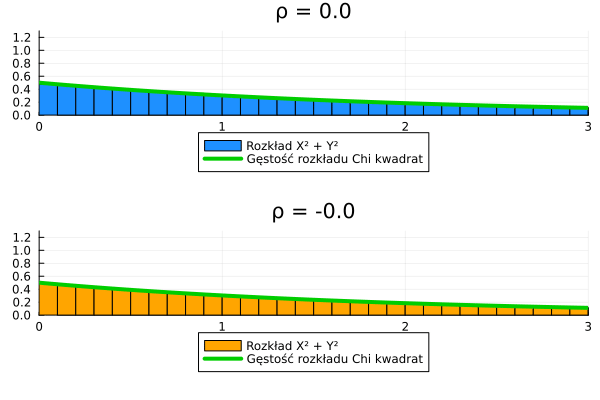

┌ Info: Saved animation to C:\Users\eemil\AppData\Local\Temp\jl_RSpqlGZcLs.gif
└ @ Plots C:\Users\eemil\.julia\packages\Plots\nuwp4\src\animation.jl:156


In [23]:
anim = @animate for rho in 0:0.05:0.95
    
    pos_sample = multivariate_normal(100_000, 2, [1 rho; rho 1], [0, 0])
    neg_sample = multivariate_normal(100_000, 2, [1 -rho; -rho 1], [0, 0])

    X_pos = pos_sample[:, 1]
    Y_pos = pos_sample[:, 2]

    X_neg = neg_sample[:, 1]
    Y_neg = neg_sample[:, 2]

    h1 = histogram(
        X_pos.^2 .+ Y_pos.^2,
        normalize=:pdf,
        color=:dodgerblue1,
        xlims=(0, 3),
        ylims=(0, 1.3),
        label="Rozkład X² + Y²",
        title="ρ = $rho",
        legend=:outerbottom
    )

    plot!(
        LinRange(0, 3, 100),
        pdf.(Chisq(2), LinRange(0, 3, 100)),
        color=:green3,
        lw=4,
        label="Gęstość rozkładu Chi kwadrat",
    )

    h2 = histogram(
        X_neg.^2 .+ Y_neg.^2,
        normalize=:pdf,
        color=:orange,
        xlims=(0, 3),
        ylims=(0, 1.3),
        label="Rozkład X² + Y²",
        title="ρ = $(-rho)",
        legend=:outerbottom
    )

    plot!(
        LinRange(0, 3, 100),
        pdf.(Chisq(2), LinRange(0, 3, 100)),
        color=:green3,
        lw=4,
        label="Gęstość rozkładu Chi kwadrat",
    )

    plot(h1, h2, link=:x, layout=@layout grid(2, 1))
end

gif(anim, fps=3)

Jak widać z powyższej animacji znak kowariancji pomiędzy dwoma zmiennymi nie ma znaczenia na rozkład $X^2 + Y^2$. Jednakże czym większy jej, tym większa skośność prawostronna rozkładu i coraz bardziej odbiega on od $\Chi^2(2)$. Może się dziać tak, gdyż granicznym przypadkiem, gdy $\rho_{XY} = 1$ jest równość $Y = aX$ (brak współczynnika $b$ wynika z tego, że obie zmienne pochodzą z rozkładu standardowego, a więc mają te same średnie). Tym samym $X^2 + Y^2 = (1 + a^2)X^2$. Możemy to zaobserwować na animacji, gdzie dla dużych wartości współczynnika korelacji rozkład zaczyna przypominać ten przedstawiony na wykresie poniżej. 

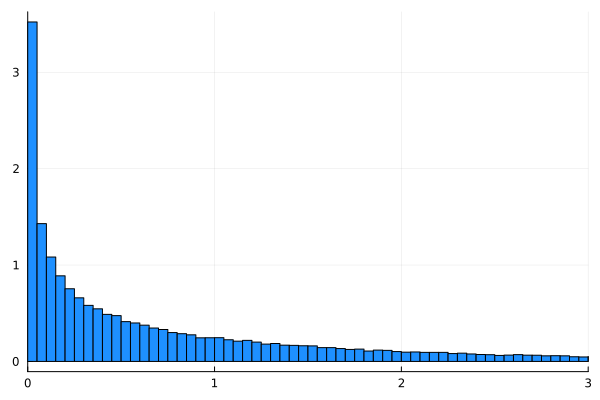

In [26]:
histogram(randn(100_000).^2, normalize=:pdf, color=:dodgerblue1, legend=false, xlims=(0, 3))